# Decision Tree Regression
This will load the csv testing and training files into Dataframes

Your Directory should be set up like this:
```
.
│
├── Notebook_Files
│   ├── Data Normalization.ipynb
│   ├── Master Template.ipynb
│   └── Random Forrest.ipynb
├── Source
│   ├── sample_submission.csv
│   ├── test.csv
│   └── train.csv
└── tmdb-box-office-prediction.zip

```

`train_df` - Holds training data

`test_df` - Holds testing data

`orig_df` - Original training data

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
import matplotlib.pyplot as plt



In [2]:
train_df = pd.read_csv('../Source/train.csv')
test_df = pd.read_csv("../Source/test.csv")
orig_df = pd.read_csv('../Source/train.csv')


## normalize(df) function
This function needs to be ran on both testing and training data
It takes in a Pandas DataFrame and returns a DataFrame
```
How to use:
df = normalize(df)
```

In [3]:
def encode_list(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    for i in data:
        genre.append(i.get(json_tag))
    return genre

def encode_list_to_count(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    count = 0
    for i in data:
        count += 1
    return count


def normalize(df):
    
    mlb = MultiLabelBinarizer()
    
    ## Count spoken languages 
    df['language_count'] = df['spoken_languages'].apply(lambda x: encode_list_to_count(x, 'iso_639_1'))
    df.pop('spoken_languages')
    
    ## Count Producion COuntry
    df['prod_country_encoded'] = df['production_countries'].apply(lambda x: encode_list(x, 'name'))
    df['produced_in_usa'] = df['prod_country_encoded'].apply(lambda x: 1 if 'United States of America' in x else 0)
    df['prod_country_counted'] = df['production_countries'].apply(lambda x: encode_list_to_count(x, 'name'))
    df.pop('production_countries')
    df.pop('prod_country_encoded')
    
    ## Encode Genre
    df['genre_encoded'] = df['genres'].apply(lambda x: encode_list(x, 'name'))
    df_encoded = pd.DataFrame(mlb.fit_transform(df['genre_encoded']),columns=mlb.classes_, index=df.index)
    df = pd.concat([df,df_encoded], axis=1)
    df.pop('genres')
    df.pop('genre_encoded')
    
    ## Run Time
    df['runtime'] = df['runtime'].replace(np.nan, 0)
    
    ## Crew Count
    df['count_of_crew'] = df['crew'].apply(lambda x: encode_list_to_count(x,'cred_id' ))
    df. pop('crew')

    ## Cast Count
    df['count_of_cast'] = df['cast'].apply(lambda x: encode_list_to_count(x,'cast_id' ))
    df. pop('cast')
    
    ## Production Companies Count
    df['production_companies_count'] = df['production_companies'].apply(lambda x: encode_list_to_count(x,'name' ))
    df. pop('production_companies')
    
    
    ## ENCODE IF ORIGINAL LANGUAGE WAS ENGLISH
    df['orig_lang_is_eng'] = df['original_language'].apply(lambda x: 1 if 'en' in x else 0)
    df.pop('original_language')
    
    ## Cast date to a date type and correct outliers
    current_year = pd.Timestamp(year=2023, month=1, day=1, hour=0, minute=0, second=0)
    df['date'] = pd.to_datetime(df['release_date'])
    df['date'] = df['date'].apply(lambda x: x - pd.DateOffset(years=100) if x > current_year else x)
    df.pop('release_date')
    
    ## Create release month int value
    df['release_month'] = df["date"].dt.month
    df.pop('date')  ## You can remove this if you want to used the date somehow
    
    ## Encode Collection status 
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: encode_list_to_count(x, 'name'))
    
    # drop irrelevant/unused columns
    df.pop('tagline')
    df.pop('Keywords')
    df.pop('overview')
    df.pop('id')
    df.pop('belongs_to_collection')
    df.pop('homepage')
    df.pop('imdb_id')
    df.pop('original_title')
    df.pop('poster_path')
    df.pop('title')
    df.pop('status')
    
    return df

### Normalize Train and Test data

In [4]:
train_df = normalize(train_df)
test_df = normalize(test_df)

### Adding average to budget values of 0

In [5]:
# var holding total budget
total_budget = 0
count = 0

# for loop traversing budget
for entry in train_df['budget']:
    total_budget += entry
    if entry != 0:
        count += 1
    
# finding average and adding it to entries with 0 value
budget_avg = total_budget / count
train_df.loc[train_df['budget'] == 0, 'budget'] = budget_avg
train_df[:5]

,budget,popularity,runtime,revenue,language_count,produced_in_usa,prod_country_counted,Action,Adventure,Animation,...,Science Fiction,TV Movie,Thriller,War,Western,count_of_crew,count_of_cast,production_companies_count,orig_lang_is_eng,release_month
0,1.400000e+07,6.575393,93.0,12314651,1,1,1,0,0,0,...,0,0,0,0,0,72,24,3,1,2
1,4.000000e+07,8.248895,113.0,95149435,1,1,1,0,0,0,...,0,0,0,0,0,9,20,1,1,8
2,3.300000e+06,64.299990,105.0,13092000,1,1,1,0,0,0,...,0,0,0,0,0,64,51,3,1,10
3,1.200000e+06,3.174936,122.0,16000000,2,0,1,0,0,0,...,0,0,1,0,0,3,7,0,0,3
4,3.089305e+07,1.148070,118.0,3923970,1,0,1,1,0,0,...,0,0,1,0,0,2,4,0,0,2


In [6]:
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# split data
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

# scale feature data
X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check size of sets
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(2400, 31)
(600, 31)
(2400,)
(600,)


## GridSearch for best parameters

In [17]:
# import tools
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
# dictionary with parameters to test
params = {    'max_depth': [5, 6, 7, 8],
              'criterion': ['squared_error','absolute_error'],
              'min_weight_fraction_leaf': [0.01, 0.001, 0.0001, 0.1],
              'min_samples_split': [2,3,4,5,6] }

# create regressor
regressor = DecisionTreeRegressor(random_state=2)

# create grid
xgb_grid = GridSearchCV(regressor,
                        params,
                        cv = 10,
                        scoring='neg_mean_squared_error',
                        verbose=1)

# fit the grid
xgb_grid.fit(X_train, y_train)

# see results
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits



KeyboardInterrupt



In [7]:
# import tools
from sklearn import metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# using best params
# 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0001
DTree_best = DecisionTreeRegressor(random_state=2,criterion='squared_error', max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001)
DTree_best.fit(X_train, y_train)
y_predict = DTree_best.predict(X_test)

R2 : 0.4440512979882748 
RMSE: 92272820.19707581


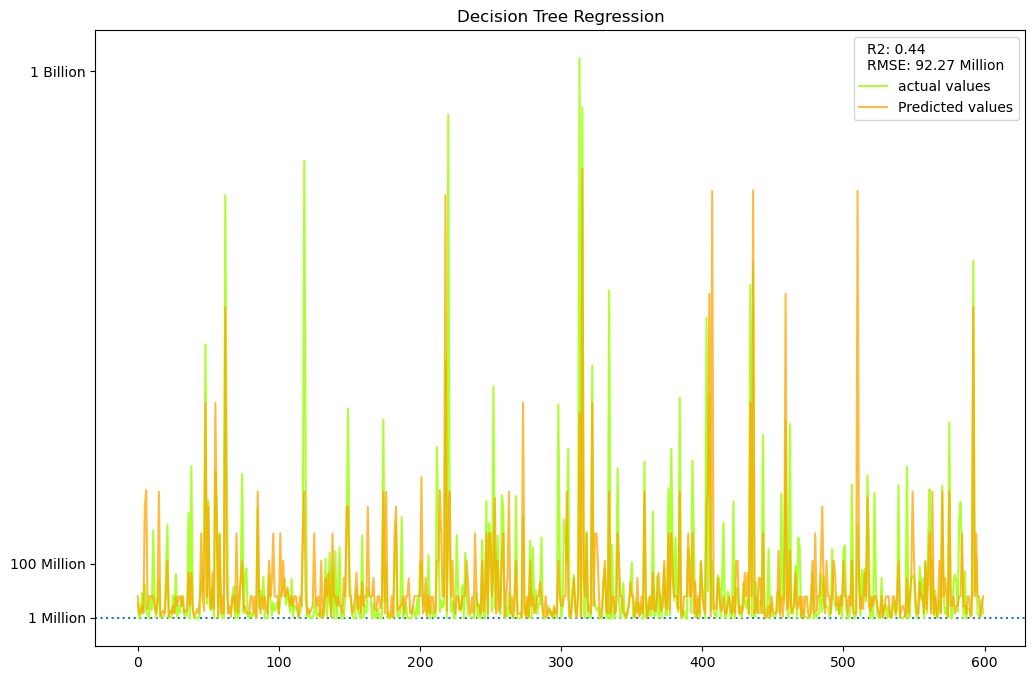

In [8]:
plt.figure(figsize=(12, 8))
plt.title("Decision Tree Regression")
plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])
# Draw line for 0 values
plt.axhline(y=0, linestyle='dotted')
# plotting the graph for the actual values
plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

# plotting the graph for predictions
plt.plot([i for i in range(len(y_test))],y_predict, label="Predicted values", c='orange',alpha=0.75,zorder=10)



mse = metrics.mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_predict)
print( f"R2 : {r2} \nRMSE: {rmse}")
plt.legend(title=f"R2: {r2:.2f}\nRMSE: {(rmse/1000000):.2f} Million")
plt.show()

### Averaging Results across 100  Train Test Splits

In [31]:
from sklearn.tree import DecisionTreeRegressor
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split data
train_df = pd.read_csv('../Source/train.csv')
train_df = normalize(train_df)
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

regr = DecisionTreeRegressor(max_depth=5)
r2_average = 0;
rmse_average = 0;
number_of_loops = 100

for j in range(0,number_of_loops):
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_loop = sc_X.fit_transform(X)
    y_loop = sc_y.fit_transform(pd.DataFrame(y))
    X_train, X_test, y_train, y_test = train_test_split(X_loop, y_loop, test_size=.10, random_state=j)
    model = DecisionTreeRegressor(random_state=2,criterion='squared_error', max_depth=6, min_samples_split=6, min_weight_fraction_leaf=0.0001)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #  fitting the size of the plot
    #plt.figure(figsize=(12, 8))
    #plt.title(f"ADABoost\nRandom State {j}")
    #plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])


    y_pred = model.predict(X_test)
    y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred)) 
    y_test = sc_y.inverse_transform(pd.DataFrame(y_test)) 

    # Draw line for 0 values
    #plt.axhline(y=0, linestyle='dotted')

    # plotting the graph for the actual values
    #plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

    # plotting the graph for predictions
    #plt.plot([i for i in range(len(y_test))],y_pred, label="Predicted values", c='orange', alpha=0.75)#, s=5)

    
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)
    r2_average += r2
    rmse_average += rmse
    print( f"R2: {r2} RMSE: {rmse/1000000}\n j = {j}")
    #plt.legend(title=f"r2_score:  {r2:.3f}\nRMSE:  {rmse/1000000:.2f} million")
    #plt.savefig(f"./Plots/ADA_Boost_{j}.png")
print(f"\n R2 average: {r2_average/number_of_loops}\n RMSE Average: {(rmse_average/number_of_loops)/1000000}")

#plt.show()


R2: 0.6368908011617893 RMSE: 90.23850027531502
 j = 0
R2: 0.5304729463811491 RMSE: 84.69530008145212
 j = 1
R2: 0.37623917812210417 RMSE: 89.99163155712606
 j = 2
R2: 0.48762496893623497 RMSE: 93.505686063816
 j = 3
R2: 0.4715600599746984 RMSE: 97.89115726428905
 j = 4
R2: 0.5209641342984569 RMSE: 67.12695045456098
 j = 5
R2: 0.6557743012221409 RMSE: 99.53798995420173
 j = 6
R2: 0.6366536084482923 RMSE: 90.48326372281772
 j = 7
R2: 0.5987696695750802 RMSE: 86.71909667826883
 j = 8
R2: 0.6683711340665869 RMSE: 68.34802413560237
 j = 9
R2: 0.557390950245699 RMSE: 96.12736633268216
 j = 10
R2: 0.30959843119096553 RMSE: 108.05267176906797
 j = 11
R2: 0.23457876276635992 RMSE: 103.41765479606862
 j = 12
R2: 0.08311344093316919 RMSE: 99.88925228981417
 j = 13
R2: 0.5760363627694691 RMSE: 100.4712354226048
 j = 14
R2: 0.5146564074686251 RMSE: 100.74054254821789
 j = 15
R2: 0.6230012217090206 RMSE: 101.29765833502228
 j = 16
R2: 0.4076311225423451 RMSE: 114.500872253446
 j = 17
R2: 0.569459742

In [6]:
pd.set_option('display.max_columns', None)
orig_df[:5]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [6]:


import dataframe_image as dfi
pd.set_option("display.max_column", None)
pd.set_option("display.max_colwidth", None)
pd.set_option('display.width', -1)
dfi.export(orig_df[:10], "table.png")

Unable to enlarge image with Chrome, it is a known bug with version 111 and 112
                    You could try to install an individual Chrome dev version and set chrome_path to it
                    or try 'df.dfi.export('df.png', table_conversion="selenium")'


In [6]:
import dataframe_image as dfi

dfi.export(
    orig_df[:10],
    "table.png",
    table_conversion="matplotlib"
)

/usr/lib/python3.10/site-packages/dataframe_image/_matplotlib_table.py:151: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  bbox = t.get_window_extent(renderer=self.renderer)
/usr/lib/python3.10/site-packages/dataframe_image/_matplotlib_table.py:151: UserWarning: Glyph 47536 (\N{HANGUL SYLLABLE RIN}) missing from current font.
  bbox = t.get_window_extent(renderer=self.renderer)
/usr/lib/python3.10/site-packages/dataframe_image/_matplotlib_table.py:151: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  bbox = t.get_window_extent(renderer=self.renderer)
/usr/lib/python3.10/site-packages/dataframe_image/_matplotlib_table.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  bbox = t.get_window_extent(renderer=self.renderer)
/usr/lib/python3.10/site-packages/dataframe_image/_matplotlib_table.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  bbox = t.get_window_

In [7]:
orig_df

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0109403,en,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,...,4/22/94,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was supposed to be a routine prisoner trans...,Chasers,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de...",1596687
2996,2997,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,tt2364975,sv,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,...,3/28/13,102.0,"[{'iso_639_1': 'sv', 'name': 'svenska'}]",Released,NaN,We Are the Best!,"[{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...","[{'cast_id': 5, 'character': 'Bobo', 'credit_i...","[{'credit_id': '5716b72ac3a3686678012c84', 'de...",180590
2997,2998,NaN,65000000,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",NaN,tt0116908,en,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,...,10/11/96,120.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What's forgotten is not always gone.,The Long Kiss Goodnight,"[{'id': 441, 'name': 'assassination'}, {'id': ...","[{'cast_id': 10, 'character': 'Samantha Caine ...","[{'credit_id': '52fe443a9251416c7502d579', 'de...",89456761
2998,2999,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www